In [1]:
#Collaborated with Sakshi Vattikuti
#Accuracy(AUC score):85.86%
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
rain_data = pd.read_csv('Weather.csv')
rain_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2010-12-25,NorahHead,17.7,25.2,0.0,NaN,NaN,NNE,39.0,S,...,76.0,1017.7,1012.1,NaN,NaN,22.3,24.3,No,0.0,No
1,2013-06-08,Darwin,22.9,31.6,0.0,7.4,10.9,E,57.0,ESE,...,40.0,1012.6,1009.9,1.0,1.0,26.2,31.2,No,0.0,No
2,2009-04-27,GoldCoast,14.7,27.6,0.0,NaN,NaN,W,31.0,WNW,...,32.0,1014.9,1012.3,NaN,NaN,23.8,26.4,No,0.0,No
3,2011-09-04,GoldCoast,13.4,22.7,0.0,NaN,NaN,SSE,44.0,SSE,...,59.0,1029.0,1026.1,NaN,NaN,19.1,20.7,No,5.0,Yes
4,2015-01-06,Nhil,15.5,37.9,0.0,NaN,NaN,ESE,46.0,ESE,...,20.0,1018.0,1015.2,NaN,NaN,22.1,36.4,No,0.0,No


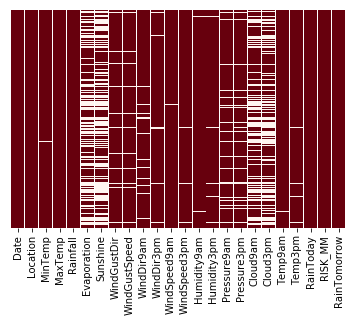

In [3]:
# Visualising missing data:
sns.heatmap(rain_data.isnull(),yticklabels=False,cbar=False,cmap='Reds_r')

In [4]:
# High percentage of missing data for Evaporation, Sunshine, Cloud9am and Cloud3pm features.
# Date, Location and RISK_MM will be removed.
# Lastly, remove any observations/rows with missing data
rain_data.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm','RISK_MM','Date','Location'],axis=1,inplace=True)
rain_data.dropna(inplace=True)
rain_data[['RainTomorrow','RainToday']] = rain_data[['RainTomorrow','RainToday']].replace({'No':0,'Yes':1})

0    87848
1    25019
Name: RainTomorrow, dtype: int64


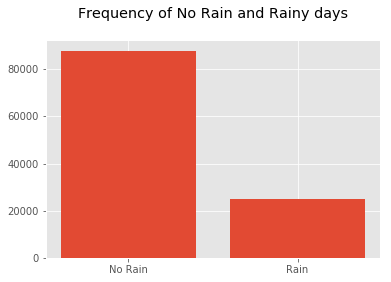

In [5]:
# Frequency of Rainy and No Rain:
mpl.style.use('ggplot')
plt.figure(figsize=(6,4))
plt.hist(rain_data['RainTomorrow'],bins=2,rwidth=0.8)
plt.xticks([0.25,0.75],['No Rain','Rain'])
plt.title('Frequency of No Rain and Rainy days\n')
print(rain_data['RainTomorrow'].value_counts())

(0, 100)

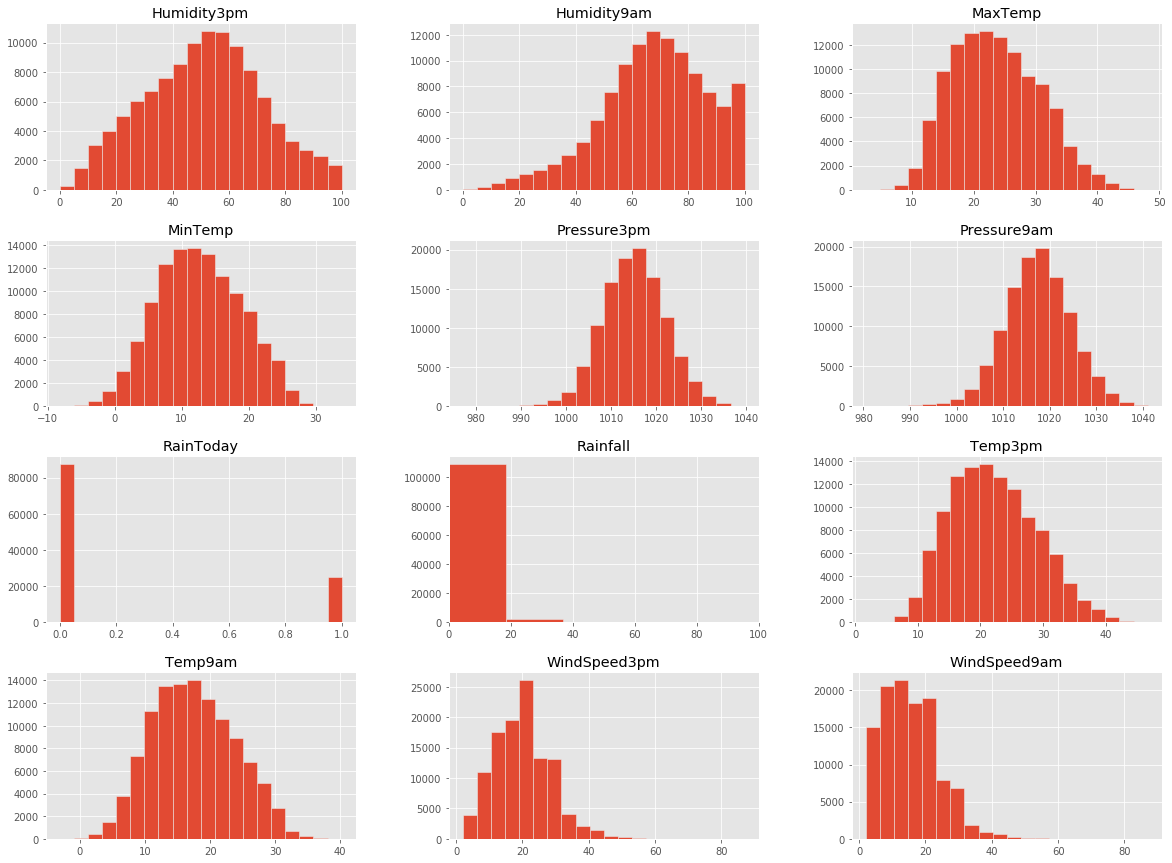

In [6]:
# Segregating our numerical features from the categorical
rain_data_num = rain_data[['MinTemp','MaxTemp','Rainfall','WindSpeed9am','WindSpeed3pm',
                           'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm',
                           'Temp9am','Temp3pm','RainToday','RainTomorrow']]

# Histogram of each numerical feature
mpl.rcParams['patch.force_edgecolor'] = True
ax_list = rain_data_num.drop(['RainTomorrow'],axis=1).hist(figsize=(20,15),bins=20)
ax_list[2,1].set_xlim((0,100))

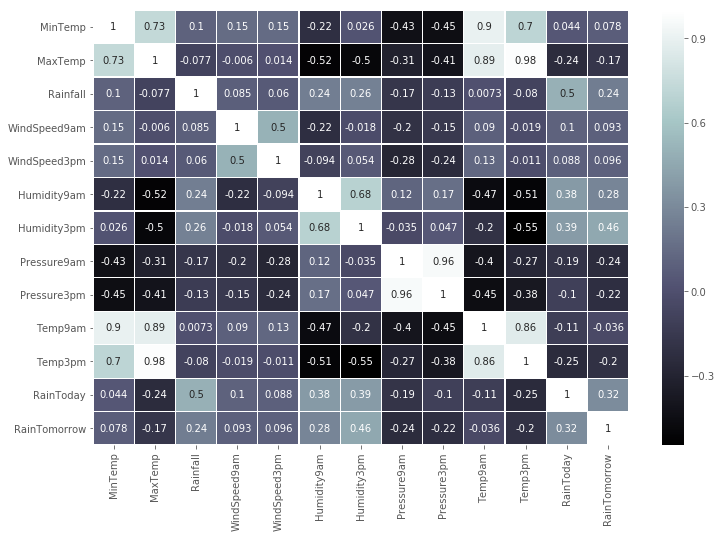

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(rain_data_num.corr(),annot=True,cmap='bone',linewidths=0.25)

In [8]:
# Creating dummy variables for the categorical features:
WindGustDir_data = pd.get_dummies(rain_data['WindGustDir'])
WindDir9am_data = pd.get_dummies(rain_data['WindDir9am'])
WindDir3pm_data = pd.get_dummies(rain_data['WindDir3pm'])

# Dataframe of the categorical features
rain_data_cat = pd.concat([WindGustDir_data,WindDir9am_data,WindDir3pm_data],
                          axis=1,keys=['WindGustDir','WindDir9am','WindDir3pm'])

# Combining the Numerical and Categorical/Dummy Variables
rain_data = pd.concat([rain_data_num,rain_data_cat],axis=1)

In [9]:
from sklearn.model_selection import train_test_split

X = rain_data.drop(['RainTomorrow'],axis=1)
y = rain_data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=88)

In [10]:
from sklearn.ensemble import RandomForestClassifier
# Out of Bag (oob) set to True. We will compare the oob_score with accuracy to see if they differ by much
# n_estimators, or number of decision trees set to 100
rf = RandomForestClassifier(n_estimators=100,oob_score=True,random_state=88)
rf.fit(X_train,y_train)
y_rf_pred = rf.predict(X_test)

In [11]:
# No Rain and Rain frequency in test set
print(y_test.value_counts())
null_accuracy = float(y_test.value_counts().head(1) / len(y_test))
print('Null Accuracy Score: {:.2%}'.format(null_accuracy))

0    26299
1     7562
Name: RainTomorrow, dtype: int64
Null Accuracy Score: 77.67%


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
print('Accuracy Score: {:.2%}'.format(accuracy_score(y_test,y_rf_pred),'\n'))
print('Out of Bag Accuracy Score: {:.2%}'.format(rf.oob_score_),'\n')
print('Confusion Matrix:\n',confusion_matrix(y_test,y_rf_pred))

Accuracy Score: 84.79%
Out of Bag Accuracy Score: 84.88% 

Confusion Matrix:
 [[25174  1125]
 [ 4025  3537]]


In [13]:
# Using feature_importance_ for feature selection
feature_importance_rf = pd.DataFrame(rf.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(['Importance'],ascending=False)
feature_importance_rf.head(5)

,Importance
Humidity3pm,0.186503
Pressure3pm,0.079644
Pressure9am,0.071582
Humidity9am,0.071236
Temp3pm,0.065671


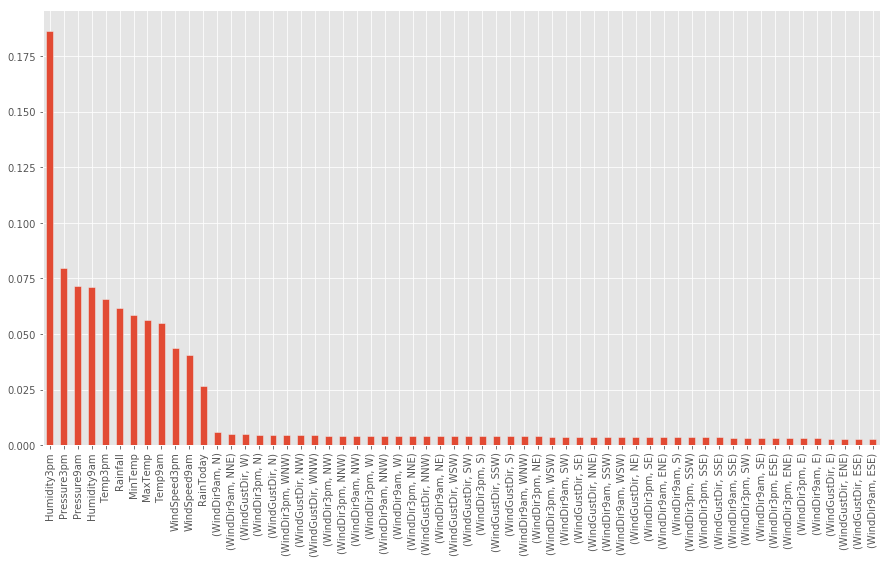

In [14]:
# Plot feature_importance
feature_importance_rf.plot(kind='bar',legend=False,figsize=(15,8))

In [15]:
features_top_5 = list(feature_importance_rf.index[0:6])

# X dataframe - with only the top 5 features
subset_1 = [X.columns.get_loc(x) for x in features_top_5]

# Split, Train, Predict
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,subset_1], y, test_size=0.30, random_state=88)
rf.fit(X_train,y_train)
y_rf_pred = rf.predict(X_test)

print('Accuracy Score: {:.2%}'.format(accuracy_score(y_test,y_rf_pred)))
print('Out of Bag Score {:.2%}:'.format(rf.oob_score_),'\n')
print('Confusion Matrix:\n',confusion_matrix(y_test,y_rf_pred))

Accuracy Score: 84.04%
Out of Bag Score 84.17%: 

Confusion Matrix:
 [[24928  1371]
 [ 4032  3530]]


In [16]:
# X dataframe - with top 5 features and the categorical variables
subset_2 = subset_1 + list(range(12,len(X.columns)))

# Split, Train, Predict
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,subset_2], y, test_size=0.30, random_state=88)
rf.fit(X_train,y_train)
y_rf_pred = rf.predict(X_test)

print('Accuracy Score: {:.2%}'.format(accuracy_score(y_test,y_rf_pred)))
print('Out of Bag Score {:.2%}:'.format(rf.oob_score_),'\n')
print('Confusion Matrix:\n',confusion_matrix(y_test,y_rf_pred))

Accuracy Score: 84.52%
Out of Bag Score 84.59%: 

Confusion Matrix:
 [[25108  1191]
 [ 4049  3513]]


In [17]:
%%time 

# Up to what number of features to plot
index = np.array(list(range(2,9)) + [15, 30, 60])

# creating list of index location
features = list(feature_importance_rf.index)
features = [X.columns.get_loc(x) for x in features]

# instantiate classifier
rf = RandomForestClassifier(n_estimators=100,random_state=88)

accuracy_rate = []

# append the accuracy rate
for i in index:
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,features[0:i]], y, test_size=0.30, random_state=88)
    rf.fit(X_train,y_train)
    y_rf_pred = rf.predict(X_test)    
    accuracy_rate.append(accuracy_score(y_test,y_rf_pred))

CPU times: user 7min 21s, sys: 9.63 s, total: 7min 31s
Wall time: 7min 32s


Text(0.5, 1.0, 'Random Forest \nAccuracy Rate vs. Number of Features')

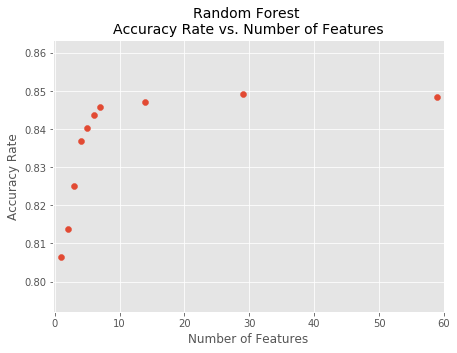

In [18]:
# Plot accuracy vs. number of features
plt.figure(figsize=(7,5))
plt.scatter(x=index-1,y=accuracy_rate)
plt.ylabel('Accuracy Rate',fontsize=12)
plt.xlabel('Number of Features',fontsize=12)
plt.xlim(-0.2,60)
plt.title('Random Forest \nAccuracy Rate vs. Number of Features', fontsize = 14)

In [19]:
# Split, Train, Predict on The 7 Features
X_train, X_test, y_train, y_test = train_test_split(X[feature_importance_rf.head(7).index], y, test_size=0.30, random_state=88)
rf.fit(X_train,y_train)
y_rf_pred = rf.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test,y_rf_pred), index=['NO RAIN','RAIN'],columns=['NO RAIN','RAIN'])

Accuracy Score (Top 7 Features): 84.38% 



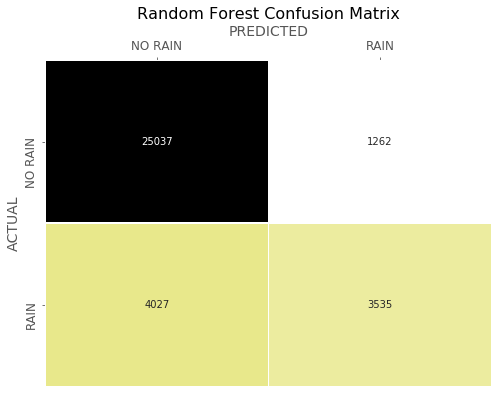

In [20]:
print('Accuracy Score (Top 7 Features): {:.2%}'.format(accuracy_score(y_test,y_rf_pred)),'\n')

# plot confusion matrix
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(cm,annot=True,cbar=False, cmap='CMRmap_r',linewidths=0.5,fmt='.0f')
ax.set_title('Random Forest Confusion Matrix',fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL',fontsize=14)
ax.set_xlabel('PREDICTED',fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)

In [21]:
TP = cm.iloc[1,1] # True Positive - Predicted Rain Correctly
TN = cm.iloc[0,0] # True Negative - Predicted No Rain Incorrectly
FP = cm.iloc[0,1] # False Positive - Predicted Rain when it didn't rain
FN = cm.iloc[1,0] # False Negative - Predicted No Rain when it did rain

In [22]:
print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
print('Specificity: {:.2%}'.format(TN/(FP+TN)))


Sensitivity: 46.75%
Specificity: 95.20%


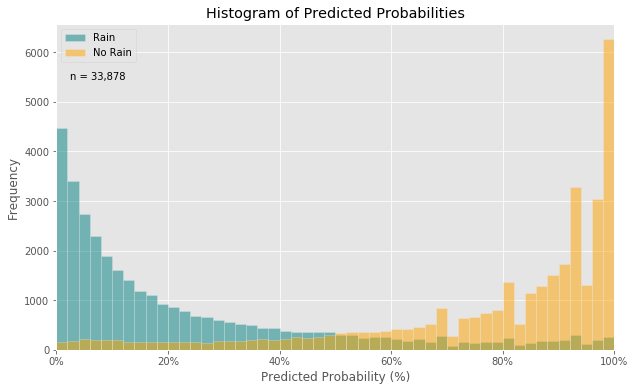

In [23]:
# proves np.array of the probability scores
y_prob_rain = rf.predict_proba(X_test)

# To convert x-axis to a percentage
from matplotlib.ticker import PercentFormatter

# Plot histogram of predicted probabilities
fig,ax = plt.subplots(figsize=(10,6))
plt.hist(y_prob_rain[:,1],bins=50,alpha=0.5,color='teal',label='Rain')
plt.hist(y_prob_rain[:,0],bins=50,alpha=0.5,color='orange',label='No Rain')
plt.xlim(0,1)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability (%)')
plt.ylabel('Frequency')

ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.text(0.025,0.83,'n = 33,878',transform=ax.transAxes)

plt.legend()

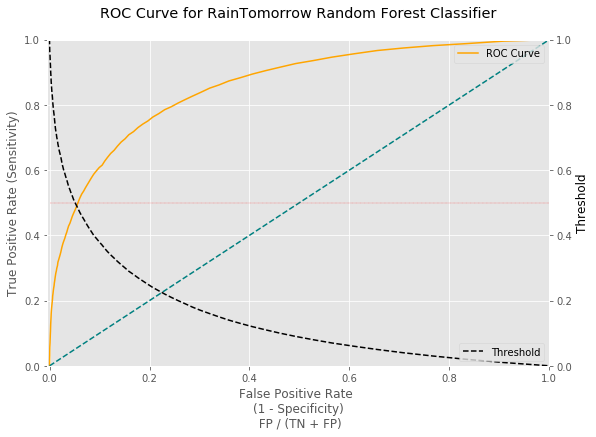

In [24]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test,y_prob_rain[:,1])

fig,ax1 = plt.subplots(figsize=(9,6))
ax1.plot(fpr, tpr,color='orange')
ax1.legend(['ROC Curve'],loc=1)
ax1.set_xlim([-0.005, 1.0])
ax1.set_ylim([0,1])
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.set_xlabel('False Positive Rate \n(1 - Specificity)\n FP / (TN + FP)')
ax1.set_title('ROC Curve for RainTomorrow Random Forest Classifier\n')

plt.plot([0,1],[0,1],linestyle='--',color='teal')
plt.plot([0,1],[0.5,0.5],linestyle='--',color='red',linewidth=0.25)

#Threshold Curve
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='black')
ax2.legend(['Threshold'],loc=4)
ax2.set_ylabel('Threshold',color='black')
ax2.set_ylim([0,1])
ax2.grid(False)

In [25]:
# Function to calc sensitivity and specificity rate for a given threshold
def evaluate_threshold(threshold):
    print('Sensitivity: {:.2%}'.format(tpr[thresholds > threshold][-1]))
    print('Specificity: {:.2%}'.format(1 - fpr[thresholds > threshold][-1]))
    
evaluate_threshold(0.25)

Sensitivity: 74.12%
Specificity: 81.33%


Accuracy Score (Top 7 Features with 25% Threshold): 79.72% 



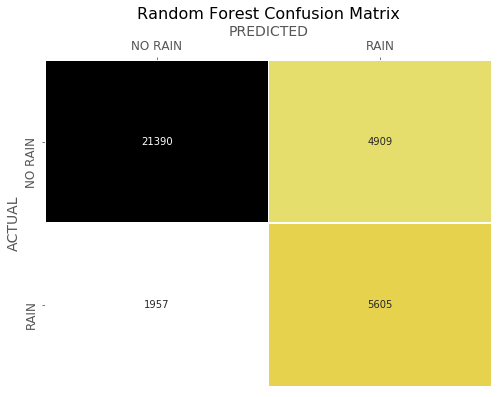

In [26]:
from sklearn.preprocessing import binarize
# change the predicted class with 25% threshold
y_pred_class = binarize(y_prob_rain,0.25)[:,1]

cm = pd.DataFrame(confusion_matrix(y_test,y_pred_class), index=['NO RAIN','RAIN'],columns=['NO RAIN','RAIN'])

print('Accuracy Score (Top 7 Features with 25% Threshold): {:.2%}'.format(accuracy_score(y_test,y_pred_class)),'\n')

# Plot Confusion Matrix
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(cm,annot=True,cbar=False, cmap='CMRmap_r',linewidths=0.5,fmt='.0f')
ax.set_title('Random Forest Confusion Matrix',fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL',fontsize=14)
ax.set_xlabel('PREDICTED',fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)

In [27]:
TP = cm.iloc[1,1] # True Positive - Predicted Rain Correctly
TN = cm.iloc[0,0] # True Negative - Predicted No Rain Incorrectly
FP = cm.iloc[0,1] # False Positive - Predicted Rain when it didn't rain
FN = cm.iloc[1,0] # False Negative - Predicted No Rain when it did rain

sens_rf = TP/(FN+TP)
spec_rf = TN/(FP+TN)

print('Sensitivity: {:.2%}'.format(sens_rf))
print('Specificity: {:.2%}'.format(spec_rf))

Sensitivity: 74.12%
Specificity: 81.33%


In [28]:
rf_auc = roc_auc_score(y_test,y_prob_rain[:,1])
print('AUC Score: {:.2%}'.format(rf_auc))

AUC Score: 85.86%
